<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/power/gasturbinemodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neqsim==2.5.35

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 45.7 MB/s eta 0:00:00


#Brayton cycle
The Brayton cycle is a thermodynamic cycle named after George Brayton that describes the workings of a constant-pressure heat engine. The original Brayton engines used a piston compressor and piston expander, but more modern gas turbine engines and airbreathing jet engines also follow the Brayton cycle. Although the cycle is usually run as an open system (and indeed must be run as such if internal combustion is used), it is conventionally assumed for the purposes of thermodynamic analysis that the exhaust gases are reused in the intake, enabling analysis as a closed system.

The efficiency of the ideal Brayton cycle is

$\eta = 1 - \frac {T_1}{T_2} = 1 - \left(\frac{P_1}{P_2}\right)^{(\gamma-1)/\gamma} $


https://en.wikipedia.org/wiki/Brayton_cycle

Ideal Brayton cycle:
1. isentropic process – ambient air is drawn into the compressor, where it is pressurized.
2. isobaric process – the compressed air then runs through a combustion chamber, where fuel is burned, heating that air—a constant-pressure process, since the chamber is open to flow in and out.
3. isentropic process – the heated, pressurized air then gives up its energy, expanding through a turbine (or series of turbines). Some of the work extracted by the turbine is used to drive the compressor.
4. isobaric process – heat rejection (in the atmosphere).

#Ideal air gas ratio

In [2]:
def ideal_air_fuld_ratio(fluid):
  elements_h = 0.0
  elements_c = 0.0
  sum_hc = 0.0
  molmass_hc = 0.0
  wtfrac_hc = 0.0

  for i in range(fluid.getNumberOfComponents()):
    if fluid.getComponent(i).isHydrocarbon():
        sum_hc = sum_hc + fluid.getComponent(i).getz()
        molmass_hc = molmass_hc + fluid.getComponent(i).getz() * fluid.getComponent(i).getMolarMass()
        elements_c = elements_c + fluid.getComponent(i).getz() * fluid.getComponent(i).getElements().getNumberOfElements("C")
        elements_h = elements_h + fluid.getComponent(i).getz() * fluid.getComponent(i).getElements().getNumberOfElements("H")

  if sum_hc == 0:
    print('no hydrocarbons in fluid ')
  else:
    wtfrac_hc = molmass_hc / fluid.getMolarMass()
    molmass_hc /= sum_hc
    elements_c /= sum_hc
    elements_h /= sum_hc
    aconst = elements_c + elements_h / 4
    afr = aconst * (32.0 + 3.76 * 28.0) / 1000.0 / molmass_hc * wtfrac_hc

    return afr

| 0                  | 1          | 2                 | 3   | 4   | 5   | 6               |
|:-------------------|:-----------|:------------------|:----|:----|:----|:----------------|
|                    | total      | GAS               |     |     |     |                 |
| nitrogen           | 7.8E-1     | 7.8E-1            |     |     |     | [mole fraction] |
| oxygen             | 2.2E-1     | 2.2E-1            |     |     |     | [mole fraction] |
|                    |            |                   |     |     |     |                 |
| Density            |            | 8.61263E0         |     |     |     | [kg/m^3]        |
| PhaseFraction      |            | 1E0               |     |     |     | [mole fraction] |
| MolarMass          | 2.88903E1  | 2.88903E1         |     |     |     | [kg/kmol]       |
| Z factor           |            | 1.00661E0         |     |     |     | [-]             |
| Heat Capacity (Cp) |            | 1.0688E0          |     |     |     | [kJ/kg

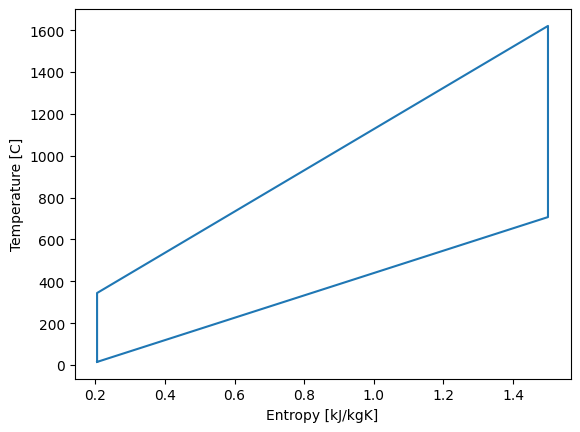

In [4]:

import neqsim
from neqsim.thermo.thermoTools import *
from neqsim.standards import ISO6976

T1 = 15.0
P1 = 1.01325

P2 = 15.4

air =  createfluid('air')
air.setPressure(P1, "bara")
air.setTemperature(T1, "C")
air.setTotalFlowRate(630.0, "kg/sec")
TPflash(air)

S1 = air.getEntropy("kJ/kgK")
H1 = air.getEnthalpy("kJ/kg")
V1 = air.getVolume("m3")
P1 = air.getPressure("bara")
T1 = air.getTemperature("C")

# 1. adiabatic process – compression
air.setPressure(P2, "bara")
PSflash(air, S1, "kJ/kgK")
printFrame(air)

S2 = air.getEntropy("kJ/kgK")
H2 = air.getEnthalpy("kJ/kg")
V2 = air.getVolume("m3")
P2 = air.getPressure("bara")
T2 = air.getTemperature("C")

#printFrame(drygas)
drygas = createfluid('dry gas')
drygas.setPressure(P2, "bara")
drygas.setTemperature(T2, "C")
drygas.setTotalFlowRate(10.0, "kg/sec")
TPflash(drygas)
print('ideal air fluid ratio ', ideal_air_fuld_ratio(drygas))

# 2. isobaric process – heat addition
GCVgas = GCV(drygas, 'kJ/kg')
energyCombustion = GCVgas*1000.0*drygas.getFlowRate("kg/sec")
air.setTemperature(1400.0)
PHflash(air, air.getEnthalpy()+energyCombustion, "J")

S3 = air.getEntropy("kJ/kgK")
H3 = air.getEnthalpy("kJ/kg")
V3 = air.getVolume("m3")
P3 = air.getPressure("bara")
T3 = air.getTemperature("C")

# 3. adiabatic process – expansion
air.setPressure(P1, "bara")
PSflash(air, S3,"kJ/kgK")

S4 = air.getEntropy("kJ/kgK")
H4 = air.getEnthalpy("kJ/kg")
V4 = air.getVolume("m3")
P4 = air.getPressure("bara")
T4 = air.getTemperature("C")

# 4. isobaric process – heat rejection
PHflash(air, H1, "kJ/kg")

S5 = air.getEntropy("kJ/kgK")
H5 = air.getEnthalpy("kJ/kg")
V5 = air.getVolume("m3")
P5 = air.getPressure("bara")
T5 = air.getTemperature("C")

idealBrytonEff = 1.0 - T1/T2
airMassFlow = air.getFlowRate("kg/sec")
fuelMassFLow = drygas.getFlowRate("kg/sec")
AFR = airMassFlow/fuelMassFLow
print("air fuel ratio ", AFR, " kg/kg")

print("air inlet flow ", V1 , " m3/sec")
print("fuel inlet flow ", drygas.getFlowRate("kg/sec") , " kg/sec")
print("compressor power ", (H2-H1)*airMassFlow/1e3 , " MW")
print("Heat of combustion ", GCVgas/1e3, " MJ/kg")
print("Turbine power ", (H3-H4)*airMassFlow/1e3, " MW")
print("Temperature of air to turbine ", T3, " C")
print("Temperature of exhaust air ", T4, " C")

powerOutput = (H3-H4)*airMassFlow/1e3 - (H2-H1)*airMassFlow/1e3
print("plant net output ", powerOutput, " MW")
netEfficiency = powerOutput/(energyCombustion/1e6)
print("efficiency ", netEfficiency)
#plot results in Ts-diagram
entropy = [S1, S2,S3, S4, S5]
temperature = [T1, T2, T3, T4, T5]
import matplotlib
import matplotlib.pyplot as plt
plt.plot(entropy, temperature);
plt.xlabel('Entropy [kJ/kgK]');
plt.ylabel('Temperature [C]');
plt.show()